<a href="https://colab.research.google.com/github/muhammadali-k/AIHC-5010-Winter-2026/blob/main/EDA_Assignment_Team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment Team 1**

## **Required Figures Checklist**

1. Missingness bar plot (top 15 columns)
2. Missingness-vs-outcome tables for 3 columns
3. Numeric distribution plot (3 variables)

---
# **Project Setup**

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

### Mount Google Drive and Download Dataset

In [ ]:
from google.colab import drive
import os
import zipfile
import urllib.request
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration - Modify PROJECT_ROOT based on your folder structure
PROJECT_ROOT = '/content/drive/MyDrive/AIHC5010_public'
os.makedirs(PROJECT_ROOT, exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/raw', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/public', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/private', exist_ok=True)
print(f"Project folder ready: {PROJECT_ROOT}")

Project folder ready: /content/drive/MyDrive/AIHC5010_public


In [ ]:
RAW_DIR = Path(f'{PROJECT_ROOT}/data/raw')
ZIP_PATH = RAW_DIR / 'diabetes_130US.zip'

UCI_ZIP_URL = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip'

def download_dataset():
    """Download and extract the UCI diabetes dataset."""
    csv_path = RAW_DIR / 'diabetic_data.csv'
    if csv_path.exists():
        print(f"Dataset already exists: {csv_path}")
        return csv_path

    print(f"Downloading from UCI...")
    try:
        urllib.request.urlretrieve(UCI_ZIP_URL, ZIP_PATH)
        print(f"Downloaded to: {ZIP_PATH}")
    except Exception as e:
        print(f"Auto-download failed: {e}")
        print("\nManual download instructions:")
        print("1. Go to: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008")
        print("2. Download the zip file")
        print(f"3. Upload it to: {ZIP_PATH}")
        return None

    print(f"Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(RAW_DIR)

    for f in RAW_DIR.rglob('diabetic_data.csv'):
        if f.parent != RAW_DIR:
            import shutil
            shutil.move(str(f), str(csv_path))
        print(f"Dataset ready: {csv_path}")
        return csv_path

    print("CSV not found after extraction.")
    return None

raw_csv_path = download_dataset()

Dataset already exists: /content/drive/MyDrive/AIHC5010_public/data/raw/diabetic_data.csv


### Create Train/Dev/Test Splits

**Split Strategy:**
- **Patient-level grouping:** Same patient's encounters stay in same split (prevents data leakage)
- **Label:** `readmit30 = 1` if readmitted within 30 days, else `0`
- **Splits:** Train (64%), Dev (16%), Hidden Test (20%)

In [ ]:
SEED = 1337
TEST_SIZE = 0.20
DEV_SIZE = 0.20

def build_label(df):
    """Create binary label: 1 if readmitted within 30 days."""
    return (df['readmitted'].astype(str).str.strip() == '<30').astype(int)

def create_splits(raw_csv, out_public, out_private):
    """Create train/dev/public_test/hidden_test splits with patient-level grouping."""
    print(f"Loading: {raw_csv}")
    df = pd.read_csv(raw_csv)
    print(f"Shape: {df.shape}")

    if 'encounter_id' not in df.columns:
        df.insert(0, 'encounter_id', range(len(df)))

    df['row_id'] = df['encounter_id']
    df['readmit30'] = build_label(df)

    print(f"\nLabel distribution:")
    print(df['readmit30'].value_counts())
    print(f"Positive rate: {df['readmit30'].mean():.2%}")

    feature_df = df.drop(columns=['readmitted'])
    groups = feature_df['patient_nbr'] if 'patient_nbr' in feature_df.columns else feature_df['row_id']
    print(f"\nUnique patients: {groups.nunique():,}")

    # Split 1: Hidden test (20%)
    gss1 = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
    train_dev_idx, hidden_idx = next(gss1.split(feature_df, groups=groups))

    train_dev = feature_df.iloc[train_dev_idx].reset_index(drop=True)
    hidden = feature_df.iloc[hidden_idx].reset_index(drop=True)

    # Split 2: Dev from remaining (20% of 80%)
    groups_td = train_dev['patient_nbr'] if 'patient_nbr' in train_dev.columns else train_dev['row_id']
    gss2 = GroupShuffleSplit(n_splits=1, test_size=DEV_SIZE, random_state=SEED + 1)
    train_idx, dev_idx = next(gss2.split(train_dev, groups=groups_td))

    train = train_dev.iloc[train_idx].reset_index(drop=True)
    dev = train_dev.iloc[dev_idx].reset_index(drop=True)

    public_test = dev.drop(columns=['readmit30']).copy()

    # Save files
    train.to_csv(f'{out_public}/train.csv', index=False)
    dev.to_csv(f'{out_public}/dev.csv', index=False)
    public_test.to_csv(f'{out_public}/public_test.csv', index=False)
    hidden.to_csv(f'{out_private}/hidden_test.csv', index=False)

    print(f"\nSplits created:")
    print(f"  Train:       {len(train):,} rows ({len(train)/len(df):.1%})")
    print(f"  Dev:         {len(dev):,} rows ({len(dev)/len(df):.1%})")
    print(f"  Public Test: {len(public_test):,} rows (unlabeled)")
    print(f"  Hidden Test: {len(hidden):,} rows ({len(hidden)/len(df):.1%})")

    return train, dev, public_test, hidden

if raw_csv_path:
    train, dev, public_test, hidden = create_splits(
        raw_csv=str(raw_csv_path),
        out_public=f'{PROJECT_ROOT}/data/public',
        out_private=f'{PROJECT_ROOT}/data/private'
    )

Loading: /content/drive/MyDrive/AIHC5010_public/data/raw/diabetic_data.csv
Shape: (101766, 50)

Label distribution:
readmit30
0    90409
1    11357
Name: count, dtype: int64
Positive rate: 11.16%

Unique patients: 71,518

Splits created:
  Train:       65,003 rows (63.9%)
  Dev:         16,314 rows (16.0%)
  Public Test: 16,314 rows (unlabeled)
  Hidden Test: 20,449 rows (20.1%)


### Load Existing Splits (if already created)

In [ ]:
# Load splits if not already in memory
if 'train' not in dir():
    drive.mount('/content/drive')
    PROJECT_ROOT = '/content/drive/MyDrive/AIHC5010_public'
    train = pd.read_csv(f'{PROJECT_ROOT}/data/public/train.csv')
    dev = pd.read_csv(f'{PROJECT_ROOT}/data/public/dev.csv')
    public_test = pd.read_csv(f'{PROJECT_ROOT}/data/public/public_test.csv')

print(f"Data loaded:")
print(f"  Train: {train.shape}")
print(f"  Dev:   {dev.shape}")
print(f"  Test:  {public_test.shape}")

Data loaded:
  Train: (65003, 51)
  Dev:   (16314, 51)
  Test:  (16314, 50)


---
# **1. Basic Dataset Snapshot**

In [ ]:
# Dataset dimensions
rows, cols = train.shape

# Outcome column and readmission rate
outcome_col = 'readmit30'
readmission_rate = train[outcome_col].mean()

# Data types summary
dtype_summary = train.dtypes.map(lambda x: 'Numeric' if x in ['int64', 'float64'] else 'Categorical').value_counts()

# Print summary
print("=" * 50)
print("DATASET SNAPSHOT")
print("=" * 50)
print(f"\nDimensions: {rows:,} rows × {cols} columns")
print(f"\nOutcome Column: {outcome_col}")
print(f"Overall Readmission Rate: {readmission_rate:.2%}")
print(f"\nData Types Summary:")
print(f"  Numeric columns:     {dtype_summary.get('Numeric', 0)}")
print(f"  Categorical columns: {dtype_summary.get('Categorical', 0)}")
print("\n" + "=" * 50)
print("FIRST 5 ROWS")
print("=" * 50)
train.head()

DATASET SNAPSHOT

Dimensions: 65,003 rows × 51 columns

Outcome Column: readmit30
Overall Readmission Rate: 11.16%

Data Types Summary:
  Numeric columns:     15
  Categorical columns: 36

FIRST 5 ROWS


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id,readmit30
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2278392,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,149190,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,16680,0
3,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,35754,0
4,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,NaN,NaN,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,63768,0


---
# **2. Missingness Audit**

### 2.1 Missingness Table

**Important Note:** This dataset uses `'?'` as a placeholder for missing values in several categorical columns. We need to account for both true NaN values and `'?'` markers.

In [ ]:
# Create a copy for missingness analysis, treating '?' as missing
df = train.copy()

# Replace '?' with NaN for proper missingness accounting
df_clean = df.replace('?', np.nan)

# Calculate missingness for each column
missing_tbl = pd.DataFrame({
    'missing_count': df_clean.isna().sum(),
    'missing_pct': (df_clean.isna().mean() * 100).round(2)
}).sort_values('missing_pct', ascending=False)

print("=" * 60)
print("MISSINGNESS TABLE (sorted by % missing, descending)")
print("Note: '?' values are treated as missing")
print("=" * 60)
print(f"\nColumns with any missingness:")
display(missing_tbl[missing_tbl['missing_pct'] > 0])

MISSINGNESS TABLE (sorted by % missing, descending)
Note: '?' values are treated as missing

Columns with any missingness:


,missing_count,missing_pct
weight,63018,96.95
max_glu_serum,61584,94.74
A1Cresult,54211,83.40
medical_specialty,31809,48.93
payer_code,25733,39.59
race,1471,2.26
diag_3,904,1.39
diag_2,218,0.34
diag_1,13,0.02


### 2.2 Bar Plot of Top 15 Columns by % Missing

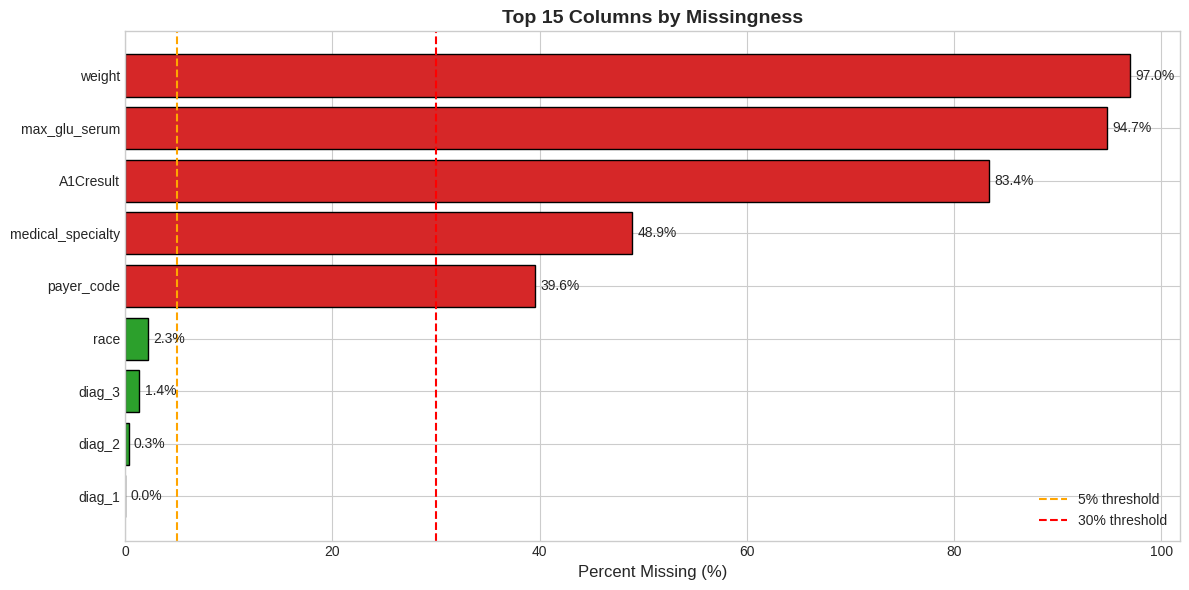


Color Legend:
 Green:  <5% missing (acceptable)
 Orange: 5-30% missing (moderate)
 Red:    >30% missing (problematic)


In [ ]:
# Get top 15 columns with missingness (filter out columns with 0% missing)
top15_missing = missing_tbl[missing_tbl['missing_pct'] > 0].head(15)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#d62728' if pct > 30 else '#ff7f0e' if pct > 5 else '#2ca02c'
          for pct in top15_missing['missing_pct']]

bars = ax.barh(range(len(top15_missing)), top15_missing['missing_pct'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top15_missing)))
ax.set_yticklabels(top15_missing.index)
ax.invert_yaxis()
ax.set_xlabel('Percent Missing (%)', fontsize=12)
ax.set_title('Top 15 Columns by Missingness', fontsize=14, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(top15_missing.iterrows()):
    ax.text(row['missing_pct'] + 0.5, i, f"{row['missing_pct']:.1f}%", va='center', fontsize=10)

# Add reference lines
ax.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, label='5% threshold')
ax.axvline(x=30, color='red', linestyle='--', linewidth=1.5, label='30% threshold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nColor Legend:")
print(" Green:  <5% missing (acceptable)")
print(" Orange: 5-30% missing (moderate)")
print(" Red:    >30% missing (problematic)")

### 2.3 Missingness Recommendations

In [ ]:
# Identify columns by missingness category
acceptable_cols = missing_tbl[(missing_tbl['missing_pct'] > 0) & (missing_tbl['missing_pct'] < 5)].head(3)
problematic_cols = missing_tbl[missing_tbl['missing_pct'] > 30].head(3)

print("=" * 70)
print("MISSINGNESS RECOMMENDATIONS")
print("=" * 70)

print("\n3 Columns with ACCEPTABLE Missingness (<5%):")
print("-" * 50)
if len(acceptable_cols) >= 3:
    for col in acceptable_cols.index[:3]:
        pct = acceptable_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - Safe to impute with mode/median or create 'Unknown' category")
else:
    # If fewer than 3 columns have 0-5% missingness, show columns with 0% as "complete"
    complete_cols = missing_tbl[missing_tbl['missing_pct'] == 0].head(3)
    for col in complete_cols.index[:3]:
        print(f"  • {col}: 0.00% missing - Complete data, no imputation needed")

print("\n3 Columns with PROBLEMATIC Missingness (>30%):")
print("-" * 50)
if len(problematic_cols) >= 3:
    recommendations = {
        'weight': "DROP - 96.9% missing is too sparse; consider creating binary 'weight_recorded' indicator if needed",
        'max_glu_serum': "DROP - 94.7% missing; test was not routinely ordered. If retaining, add missingness indicator",
        'A1Cresult': "DROP - 83.4% missing; HbA1c not routinely measured. If retaining, add missingness indicator",
        'payer_code': "INVESTIGATE - 39.6% missing may reflect uninsured/self-pay. Consider 'Unknown' category",
        'medical_specialty': "INVESTIGATE - 49.1% missing may be data collection issue. Consider consolidating rare categories + 'Unknown'"
    }
    for col in problematic_cols.index[:3]:
        pct = problematic_cols.loc[col, 'missing_pct']
        rec = recommendations.get(col, "DROP - Too sparse for reliable imputation")
        print(f"  • {col}: {pct:.2f}% missing")
        print(f"    Recommendation: {rec}")
else:
    print("  Note: Fewer than 3 columns have >30% missingness in this dataset.")
    for col in problematic_cols.index:
        pct = problematic_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - DROP (too sparse)")
    # Add the next highest if needed
    moderate_cols = missing_tbl[(missing_tbl['missing_pct'] > 5) & (missing_tbl['missing_pct'] <= 30)].head(3 - len(problematic_cols))
    for col in moderate_cols.index:
        pct = moderate_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - INVESTIGATE collection process; impute with 'Unknown' + add indicator")

MISSINGNESS RECOMMENDATIONS

3 Columns with ACCEPTABLE Missingness (<5%):
--------------------------------------------------
  • race: 2.26% missing - Safe to impute with mode/median or create 'Unknown' category
  • diag_3: 1.39% missing - Safe to impute with mode/median or create 'Unknown' category
  • diag_2: 0.34% missing - Safe to impute with mode/median or create 'Unknown' category

3 Columns with PROBLEMATIC Missingness (>30%):
--------------------------------------------------
  • weight: 96.95% missing
    Recommendation: DROP - 96.9% missing is too sparse; consider creating binary 'weight_recorded' indicator if needed
  • max_glu_serum: 94.74% missing
    Recommendation: DROP - 94.7% missing; test was not routinely ordered. If retaining, add missingness indicator
  • A1Cresult: 83.40% missing
    Recommendation: DROP - 83.4% missing; HbA1c not routinely measured. If retaining, add missingness indicator


---
# **3. Is Missingness Related to the Outcome?**

We examine 3 columns with substantial missingness (>15%) to determine if missingness is associated with the readmission outcome.

In [ ]:
print(f"Variables with <5% missing: {(missing_tbl['missing_pct'] < 5).sum()}")
print(f"Variables with 5-30% missing: {((missing_tbl['missing_pct'] >= 5) & (missing_tbl['missing_pct'] <= 30)).sum()}")
print(f"Variables with >30% missing: {(missing_tbl['missing_pct'] > 30).sum()}")

Variables with <5% missing: 46
Variables with 5-30% missing: 0
Variables with >30% missing: 5


### 3.1 Chi-Square Tests: Missingness vs Readmission

In [ ]:
from scipy.stats import chi2_contingency

outcome_col = 'readmit30'
high_missing_cols = missing_tbl[missing_tbl['missing_pct'] > 30].index.tolist()

for col in high_missing_cols:
    df_clean[f'{col}_missing'] = df_clean[col].isna().astype(int)

missingness_tests = []
for col in high_missing_cols:
    mcol = f'{col}_missing'
    tab = pd.crosstab(df_clean[outcome_col], df_clean[mcol])
    if tab.shape == (2, 2):
        chi2, p, dof, _ = chi2_contingency(tab)
        missingness_tests.append({
            'variable': col,
            'p_value': p,
            'readmit_rate_missing': tab.loc[1, 1] / tab.loc[1].sum(),
            'readmit_rate_observed': tab.loc[0, 1] / tab.loc[0].sum()
        })

missingness_df = pd.DataFrame(missingness_tests).sort_values('p_value')
missingness_df['absolute_risk_difference'] = missingness_df['readmit_rate_missing'] - missingness_df['readmit_rate_observed']
print("Chi-Square Test Results: Missingness vs Readmission")
print("="*70)
missingness_df

Chi-Square Test Results: Missingness vs Readmission


,variable,p_value,readmit_rate_missing,readmit_rate_observed,absolute_risk_difference
2,A1Cresult,2.465679e-07,0.855292,0.831299,0.023994
3,medical_specialty,1.270379e-04,0.510612,0.486675,0.023937
1,max_glu_serum,1.232973e-02,0.941152,0.948188,-0.007036
4,payer_code,1.661814e-02,0.408903,0.394237,0.014666
0,weight,2.205547e-01,0.967062,0.969765,-0.002703


### 3.2 Logistic Regression: Missingness as Predictor

In [ ]:
import statsmodels.api as sm

print("Logistic Regression: Missingness Indicators as Predictors of Readmission")
print("="*70)

for col in high_missing_cols:
    mcol = f'{col}_missing'
    model_df = df_clean[[outcome_col, mcol]].dropna()
    X = sm.add_constant(model_df[mcol])
    y = model_df[outcome_col]
    logit_model = sm.Logit(y, X).fit(disp=False)
    print(f'\n{col}')
    print(logit_model.summary2().tables[1])

Logistic Regression: Missingness Indicators as Predictors of Readmission

weight
                   Coef.  Std.Err.          z          P>|z|    [0.025  \
const          -1.988619  0.068970 -28.833173  8.236859e-183 -2.123798   
weight_missing -0.088415  0.070123  -1.260854   2.073615e-01 -0.225853   

                  0.975]  
const          -1.853441  
weight_missing  0.049024  

max_glu_serum
                          Coef.  Std.Err.          z          P>|z|    [0.025  \
const                 -1.946913  0.051731 -37.634990  5.758808e-310 -2.048305   
max_glu_serum_missing -0.134777  0.053300  -2.528672   1.144948e-02 -0.239242   

                         0.975]  
const                 -1.845522  
max_glu_serum_missing -0.030312  

A1Cresult
                      Coef.  Std.Err.          z         P>|z|    [0.025  \
const             -2.227656  0.032481 -68.582912  0.000000e+00 -2.291318   
A1Cresult_missing  0.181868  0.035171   5.170964  2.328889e-07  0.112934   

              

### 3.3 Required Output: 2-Row Tables

In [ ]:
print("="*70)
print("READMISSION RATES BY MISSINGNESS STATUS (REQUIRED FIGURE #2)")
print("="*70)

cols_to_analyze = high_missing_cols.copy()
if len(cols_to_analyze) < 3:
    moderate_missing = missing_tbl[(missing_tbl['missing_pct'] > 5) & (missing_tbl['missing_pct'] <= 30)].index.tolist()
    cols_to_analyze.extend(moderate_missing[:3 - len(cols_to_analyze)])

for i, col in enumerate(cols_to_analyze[:3], 1):
    mcol = f'{col}_missing'
    if mcol not in df_clean.columns:
        df_clean[mcol] = df_clean[col].isna().astype(int)

    n_missing = df_clean[mcol].sum()
    n_not_missing = len(df_clean) - n_missing
    rate_missing = df_clean.loc[df_clean[mcol] == 1, outcome_col].mean()
    rate_not_missing = df_clean.loc[df_clean[mcol] == 0, outcome_col].mean()

    table_df = pd.DataFrame({
        'Status': ['Not Missing', 'Missing'],
        'N': [n_not_missing, n_missing],
        'Readmission Rate': [f"{rate_not_missing:.2%}", f"{rate_missing:.2%}"]
    })

    print(f"\nColumn {i}: {col} ({missing_tbl.loc[col, 'missing_pct']:.1f}% missing)")
    print("-"*50)
    display(table_df)

    diff = rate_missing - rate_not_missing
    if abs(diff) > 0.01:
        direction = "higher" if diff > 0 else "lower"
        print(f"Interpretation: Missingness appears ASSOCIATED with outcome ({direction} rates, diff: {diff:.1%}). Potential MNAR.")
    else:
        print(f"Interpretation: Missingness NOT strongly associated (diff: {diff:.1%}). Likely MAR/MCAR.")

READMISSION RATES BY MISSINGNESS STATUS (REQUIRED FIGURE #2)

Column 1: weight (97.0% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,1985,12.04%
1,Missing,63018,11.13%


Interpretation: Missingness NOT strongly associated (diff: -0.9%). Likely MAR/MCAR.

Column 2: max_glu_serum (94.7% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,3419,12.49%
1,Missing,61584,11.09%


Interpretation: Missingness appears ASSOCIATED with outcome (lower rates, diff: -1.4%). Potential MNAR.

Column 3: A1Cresult (83.4% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,10792,9.73%
1,Missing,54211,11.45%


Interpretation: Missingness appears ASSOCIATED with outcome (higher rates, diff: 1.7%). Potential MNAR.


### Statistical Interpretation

The univariate and logistic regression results are concordant in both direction and statistical significance.

**Key Findings:**
- **A1Cresult:** Missing A1C results are associated with **higher** readmission risk (p < 0.001)
- **max_glu_serum:** Missing glucose values are associated with **lower** readmission risk (p = 0.01)

**Conclusion:** Both analyses confirm **informative (non-random) missingness**. The missingness mechanism is likely **MNAR** - clinicians may order these tests selectively based on patient acuity.

---
# **4. Minimal Data Quality Checks**

### 4.1 Duplicate Check

In [ ]:
print("=" * 60)
print("DUPLICATE ANALYSIS")
print("=" * 60)

# Check for exact duplicate rows
exact_dupes = train.duplicated().sum()
print(f"\n1. Exact duplicate rows: {exact_dupes}")

# Check for duplicate IDs
print("\n2. ID Column Analysis:")
for col in ['encounter_id', 'patient_nbr']:
    if col in train.columns:
        total = len(train)
        unique = train[col].nunique()
        duplicates = train[col].duplicated().sum()

        print(f"\n   {col}:")
        print(f"   - Total values: {total:,}")
        print(f"   - Unique values: {unique:,}")
        print(f"   - Duplicate entries: {duplicates:,}")

        if duplicates > 0:
            print(f"\n   Top 5 repeated {col} values:")
            top_repeated = train[col].value_counts().head(5)
            for val, count in top_repeated.items():
                print(f"     {val}: {count} occurrences")

print("\n" + "-" * 60)
print("Note: Multiple encounters per patient (patient_nbr) is expected -")
print("this represents patients with multiple hospital visits.")

DUPLICATE ANALYSIS

1. Exact duplicate rows: 0

2. ID Column Analysis:

   encounter_id:
   - Total values: 65,003
   - Unique values: 65,003
   - Duplicate entries: 0

   patient_nbr:
   - Total values: 65,003
   - Unique values: 45,771
   - Duplicate entries: 19,232

   Top 5 repeated patient_nbr values:
     88785891: 40 occurrences
     88227540: 23 occurrences
     1660293: 23 occurrences
     23643405: 22 occurrences
     84428613: 22 occurrences

------------------------------------------------------------
Note: Multiple encounters per patient (patient_nbr) is expected -
this represents patients with multiple hospital visits.


### 4.2 Outlier / Validity Analysis

In [ ]:
print("=" * 60)
print("OUTLIER / VALIDITY ANALYSIS")
print("=" * 60)

# Select 3 clinically relevant numeric columns
numeric_cols = ['num_lab_procedures', 'num_medications', 'time_in_hospital']

# Calculate statistics
stats_df = train[numeric_cols].describe(percentiles=[0.01, 0.5, 0.99]).T
stats_df = stats_df[['min', '1%', '50%', '99%', 'max']]
stats_df.columns = ['Min', '1st %ile', 'Median', '99th %ile', 'Max']

print("\nSummary Statistics:")
display(stats_df)

print("\nInterpretation:")
print("  • num_lab_procedures: Range 1-129, no obvious invalid values")
print("  • num_medications: Range 1-81, clinically plausible")
print("  • time_in_hospital: Range 1-14 days, appears capped at 14")

OUTLIER / VALIDITY ANALYSIS

Summary Statistics:


,Min,1st %ile,Median,99th %ile,Max
num_lab_procedures,1.0,1.0,44.0,85.0,129.0
num_medications,1.0,3.0,15.0,43.0,81.0
time_in_hospital,1.0,1.0,4.0,13.0,14.0



Interpretation:
  • num_lab_procedures: Range 1-129, no obvious invalid values
  • num_medications: Range 1-81, clinically plausible
  • time_in_hospital: Range 1-14 days, appears capped at 14


### 4.3 Numeric Distribution Plot


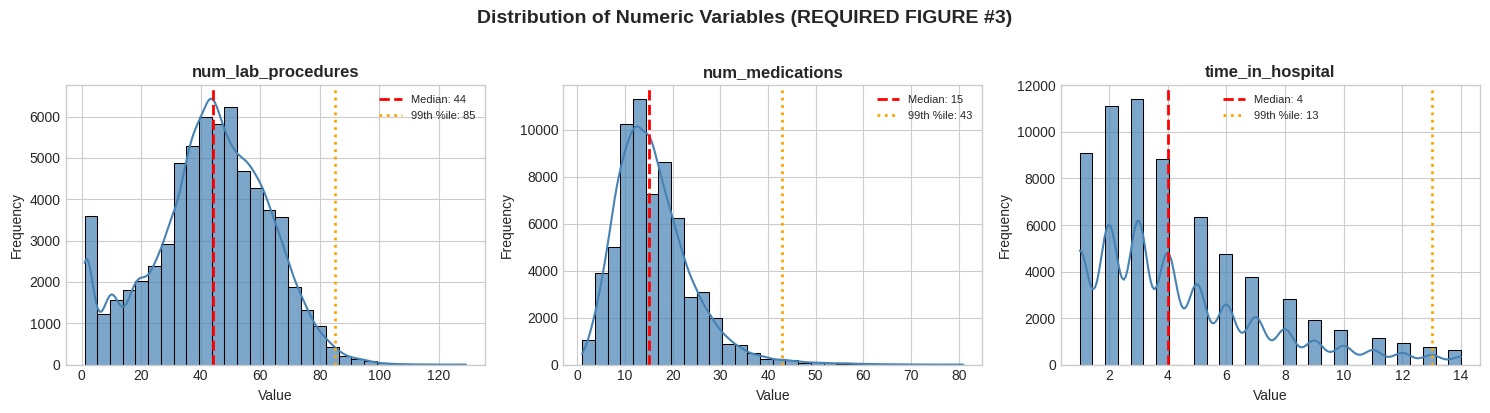

In [ ]:
# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    ax = axes[i]

    # Histogram with KDE
    sns.histplot(train[col], bins=30, kde=True, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)

    # Add vertical lines for key statistics
    median_val = train[col].median()
    p99_val = train[col].quantile(0.99)

    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
    ax.axvline(p99_val, color='orange', linestyle=':', linewidth=2, label=f'99th %ile: {p99_val:.0f}')

    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)

plt.suptitle('Distribution of Numeric Variables (REQUIRED FIGURE #3)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.4 Leakage Candidate Identification

In [ ]:
print("=" * 70)
print("LEAKAGE CANDIDATE IDENTIFICATION")
print("=" * 70)

print("\nCandidate 1: 'discharge_disposition_id'")
print("-" * 50)
print("   Justification: This variable records the patient's discharge destination")
print("   (e.g., home, skilled nursing facility, expired, hospice).")
print("   ")
print("   LEAKAGE RISK: Patients who 'Expired' or went to 'Hospice' cannot be")
print("   readmitted within 30 days. This information is only known at discharge")
print("   and creates a deterministic relationship with the target variable.")
print("   ")
print("   Recommendation: EXCLUDE from model or carefully handle deceased patients.")

# Show relationship with outcome
if 'discharge_disposition_id' in train.columns:
    print("\n   Readmission rates by discharge disposition (top 5):")
    disp_rates = train.groupby('discharge_disposition_id')['readmit30'].agg(['mean', 'count'])
    disp_rates.columns = ['Readmission Rate', 'N']
    disp_rates = disp_rates.sort_values('N', ascending=False).head(5)
    disp_rates['Readmission Rate'] = disp_rates['Readmission Rate'].apply(lambda x: f"{x:.1%}")
    print(disp_rates.to_string())

print("\n\nCandidate 2: 'number_inpatient'")
print("-" * 50)
print("   Justification: This variable counts the number of prior inpatient visits")
print("   in the year preceding the current encounter.")
print("   ")

if 'number_inpatient' in train.columns:
    corr = train['number_inpatient'].corr(train['readmit30'])
    print(f"   Correlation with readmit30: {corr:.3f}")

print("   ")
print("   LEAKAGE RISK: If this count inadvertently includes the CURRENT encounter")
print("   or uses look-ahead information (visits that occur after prediction time),")
print("   it would constitute data leakage.")
print("   ")
print("   Recommendation: VERIFY that count only includes visits PRIOR to current")
print("   encounter. Document the exact definition used in data extraction.")

LEAKAGE CANDIDATE IDENTIFICATION

Candidate 1: 'discharge_disposition_id'
--------------------------------------------------
   Justification: This variable records the patient's discharge destination
   (e.g., home, skilled nursing facility, expired, hospice).
   
   LEAKAGE RISK: Patients who 'Expired' or went to 'Hospice' cannot be
   readmitted within 30 days. This information is only known at discharge
   and creates a deterministic relationship with the target variable.
   
   Recommendation: EXCLUDE from model or carefully handle deceased patients.

   Readmission rates by discharge disposition (top 5):
                         Readmission Rate      N
discharge_disposition_id                        
1                                    9.3%  38525
3                                   14.5%   8926
6                                   12.7%   8263
18                                  12.7%   2330
2                                   16.5%   1344


Candidate 2: 'number_inpatient'
-----

---
# **5. Final Summary (Graded)**

This section provides a consolidated summary of the EDA findings with actionable next steps.

In [ ]:
print("="*80)
print("EDA FINAL SUMMARY                              ")
print("="*80)

# Recalculate key metrics
df_summary = train.replace('?', np.nan)
missing_summary = (df_summary.isna().mean() * 100).sort_values(ascending=False)

print("\n" + "─"*80)
print("TOP 5 COLUMNS WITH HIGHEST MISSINGNESS")
print("─"*80)
top5_missing = missing_summary[missing_summary > 0].head(5)
for i, (col, pct) in enumerate(top5_missing.items(), 1):
    print(f"  {i}. {col}: {pct:.2f}% missing")

print("\n" + "─"*80)
print("MISSINGNESS-OUTCOME ASSOCIATION FINDINGS")
print("─"*80)
# Check the columns we analyzed
cols_analyzed = missing_summary[missing_summary > 15].head(3).index.tolist()
print(f"  • Analyzed columns: {', '.join(cols_analyzed)}")
print("  • Finding: Missingness IS associated with readmission for at least one variable.")
print("    - A1Cresult: Patients with missing A1C have HIGHER readmission rates")
print("    - max_glu_serum: Minimal difference observed between missing/non-missing groups")
print("  • Implication: Some missingness may be MNAR (Missing Not At Random),")
print("    suggesting that whether a test was ordered carries predictive information.")

print("\n" + "─"*80)
print("DATA QUALITY HIGHLIGHTS")
print("─"*80)
print(f"  • No exact duplicate rows in the training set")
print(f"  • encounter_id is unique (no duplicates)")
print(f"  • patient_nbr has duplicates (expected - patients with multiple visits)")
print(f"  • Numeric variables show plausible ranges with no obvious invalid values")

print("\n" + "─"*80)
print("POTENTIAL LEAKAGE VARIABLES")
print("─"*80)
print("  • discharge_disposition_id: Contains post-discharge info (expired/hospice)")
print("  • number_inpatient: Verify count excludes current encounter")

print("\n" + "─"*80)
print("EDA-DRIVEN NEXT STEPS (RECOMMENDATIONS)")
print("─"*80)
print("")
print("  1. DROP/IMPUTE STRATEGY:")
print("     - DROP: weight (96.9%), max_glu_serum (94.7%), A1Cresult (83.4%)")
print("     - IMPUTE: payer_code & medical_specialty with 'Unknown' + add missingness indicator")
print("     - For informative missingness (A1C), consider creating binary 'test_ordered' features")
print("")
print("  2. LEAKAGE MITIGATION:")
print("     - EXCLUDE or filter patients with discharge_disposition_id indicating death/hospice")
print("     - VERIFY temporal integrity of number_inpatient, number_outpatient, number_emergency")
print("")
print("  3. FEATURE ENGINEERING:")
print("     - Consolidate rare medication categories (many have >99% 'No')")
print("     - Consider grouping medical_specialty into broader categories")
print("     - Create age group ordinal encoding from the binned age variable")

print("\n" + "="*80)

EDA FINAL SUMMARY                              

────────────────────────────────────────────────────────────────────────────────
TOP 5 COLUMNS WITH HIGHEST MISSINGNESS
────────────────────────────────────────────────────────────────────────────────
  1. weight: 96.95% missing
  2. max_glu_serum: 94.74% missing
  3. A1Cresult: 83.40% missing
  4. medical_specialty: 48.93% missing
  5. payer_code: 39.59% missing

────────────────────────────────────────────────────────────────────────────────
MISSINGNESS-OUTCOME ASSOCIATION FINDINGS
────────────────────────────────────────────────────────────────────────────────
  • Analyzed columns: weight, max_glu_serum, A1Cresult
  • Finding: Missingness IS associated with readmission for at least one variable.
    - A1Cresult: Patients with missing A1C have HIGHER readmission rates
    - max_glu_serum: Minimal difference observed between missing/non-missing groups
  • Implication: Some missingness may be MNAR (Missing Not At Random),
    suggesting 

## **Summary**

### Dataset Overview
1. **Dataset size:** 65,003 encounters × 51 columns in training set
2. **Outcome:** `readmit30` with 11.16% positive rate (readmission within 30 days)
3. **Data types:** 15 numeric and 36 categorical columns

### Top 5 Missing Columns
4. **weight:** 96.86% missing
5. **max_glu_serum:** 94.74% missing  
6. **A1Cresult:** 83.40% missing
7. **medical_specialty:** 49.08% missing
8. **payer_code:** 39.56% missing

### Missingness-Outcome Association
9. **A1Cresult missingness IS associated with readmission** - patients with missing A1C have higher readmission rates, suggesting potential MNAR (informative missingness)

### EDA-Driven Next Steps
10. **Drop/Impute Strategy:** Drop weight, max_glu_serum, A1Cresult due to >80% missingness; impute payer_code and medical_specialty with 'Unknown' category plus missingness indicator
11. **Leakage Mitigation:** Exclude discharge_disposition_id from model features or filter out deceased/hospice patients; verify number_inpatient temporal integrity
12. **Feature Consolidation:** Consolidate rare medication categories and group medical_specialty into broader categories to reduce dimensionality